Found 147 songs and vocab size 24
PCA reduced shape: (147, 2)


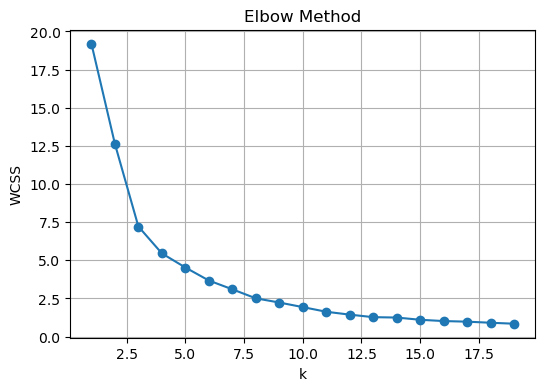

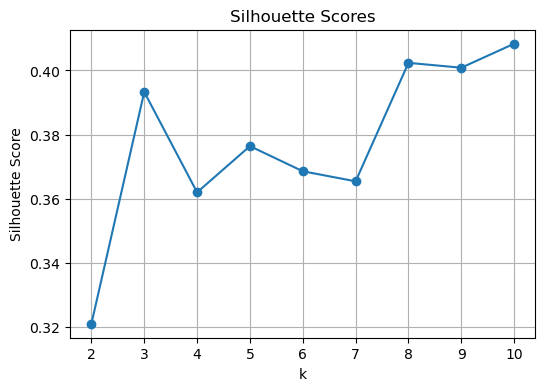

Chosen best_k (by silhouette): 10 with score 0.4084
Clustering Accuracy (majority-genre mapping): 33.33%
Saved 'song_clusters.csv'.
Purity: 0.3333
NMI:    0.1001
ARI:    0.0114
FMI:    0.1529
Keywords: ['piano', 'calm', 'slow'] -> Predicted Genre: classical
Keywords: ['guitar', 'emotional', 'distorted'] -> Predicted Genre: classical
Keywords: ['synth', 'mellow', 'distorted'] -> Predicted Genre: rock


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from collections import Counter, defaultdict

# --------------------------
# Reproducibility
# --------------------------
RANDOM_SEED = 160
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# --------------------------
# Utilities: TF-IDF (no sklearn)
# --------------------------
def build_corpus_from_keywords(df, kw_cols=('keyword_1','keyword_2','keyword_3')):
    """Return list of 'documents' (strings), vocabulary list, and per-doc token lists."""
    docs = []
    tokenized = []
    for _, row in df.iterrows():
        tokens = [str(row[c]).strip() for c in kw_cols]
        tokenized.append(tokens)
        docs.append(" ".join(tokens))
    # build vocabulary (sorted for deterministic ordering)
    vocab = sorted({tok for tokens in tokenized for tok in tokens})
    return docs, tokenized, vocab

def compute_tfidf_matrix(tokenized_docs, vocab):
    """Compute TF-IDF matrix (N_docs x Vocab) manually.
       tokenized_docs: list of token lists for each doc (e.g. [['piano','calm','slow'], ...])
       vocab: list of tokens
    """
    N = len(tokenized_docs)
    V = len(vocab)
    idx = {w:i for i,w in enumerate(vocab)}
    # document frequency
    df_counts = np.zeros(V, dtype=float)
    # term frequencies per doc
    tf_matrix = np.zeros((N, V), dtype=float)
    for d, tokens in enumerate(tokenized_docs):
        counts = Counter(tokens)
        total_terms = len(tokens) if len(tokens)>0 else 1
        for t, c in counts.items():
            if t in idx:
                tf_matrix[d, idx[t]] = c / total_terms
        # df: presence (count doc if token present)
        present = set(tokens)
        for t in present:
            if t in idx:
                df_counts[idx[t]] += 1.0
    # idf: log(N / df) (use smoothing to avoid zero df)
    df_counts[df_counts==0] = 1.0
    idf = np.log(N / df_counts)
    # tf-idf
    tfidf = tf_matrix * idf[np.newaxis, :]
    # optional: normalize rows (L2) so cosine later behaves well
    norms = np.linalg.norm(tfidf, axis=1, keepdims=True)
    norms[norms==0] = 1.0
    tfidf = tfidf / norms
    return tfidf, idf

# --------------------------
# PCA via SVD
# --------------------------
def pca_svd(X, n_components=2):
    """Center data and compute top n_components via SVD. Return transformed X and components."""
    X = np.asarray(X, dtype=float)
    mean = X.mean(axis=0)
    Xc = X - mean
    # economy SVD
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    components = Vt[:n_components, :].T    # shape (n_features, n_components)
    X_reduced = Xc.dot(components)         # shape (n_samples, n_components)
    return X_reduced, components, mean

# --------------------------
# Distance helpers
# --------------------------
def euclidean_cdist(A, B):
    """Return pairwise euclidean distances between rows of A and rows of B."""
    # (a-b)^2 = a^2 + b^2 - 2ab
    AA = (A**2).sum(axis=1)[:, None]
    BB = (B**2).sum(axis=1)[None, :]
    AB = A.dot(B.T)
    d2 = AA + BB - 2*AB
    d2[d2 < 0] = 0.0
    return np.sqrt(d2)

def cosine_similarity(A, B):
    """Return cosine similarity matrix A @ B.T / (||A|| * ||B||)"""
    A = np.asarray(A, dtype=float)
    B = np.asarray(B, dtype=float)
    A_norms = np.linalg.norm(A, axis=1, keepdims=True)
    B_norms = np.linalg.norm(B, axis=1, keepdims=True)
    A_norms[A_norms==0] = 1.0
    B_norms[B_norms==0] = 1.0
    return (A @ B.T) / (A_norms @ B_norms.T)

# --------------------------
# KMeans with kmeans++ initialization
# --------------------------
def kmeans_plus_plus_init(X, k, random_state=None):
    rng = np.random.RandomState(random_state)
    n = X.shape[0]
    centers = np.empty((k, X.shape[1]), dtype=float)
    # pick first center uniform
    first = rng.randint(0, n)
    centers[0] = X[first]
    # distances to nearest center
    closest_d2 = ((X - centers[0])**2).sum(axis=1)
    for i in range(1, k):
        probs = closest_d2 / closest_d2.sum()
        # choose next center
        r = rng.rand()
        cumulative = np.cumsum(probs)
        next_idx = np.searchsorted(cumulative, r)
        centers[i] = X[next_idx]
        # update distances
        d2 = ((X - centers[i])**2).sum(axis=1)
        closest_d2 = np.minimum(closest_d2, d2)
    return centers

def kmeans(X, k, max_iters=200, tol=1e-4, random_state=None):
    """Single run of kmeans with kmeans++ initialization. Returns labels, centers."""
    X = np.asarray(X, dtype=float)
    rng = np.random.RandomState(random_state)
    n, d = X.shape
    centers = kmeans_plus_plus_init(X, k, random_state=rng.randint(0, 2**31-1))
    labels = np.zeros(n, dtype=int)
    for it in range(max_iters):
        # assign
        dists = euclidean_cdist(X, centers)  # shape (n, k)
        new_labels = np.argmin(dists, axis=1)
        # update centers
        new_centers = np.zeros_like(centers)
        for j in range(k):
            pts = X[new_labels == j]
            if pts.shape[0] == 0:
                # reinit empty cluster to random point
                new_centers[j] = X[rng.randint(0, n)]
            else:
                new_centers[j] = pts.mean(axis=0)
        # check convergence
        shift = np.linalg.norm(new_centers - centers)
        centers = new_centers
        labels = new_labels
        if shift <= tol:
            break
    return labels, centers

def kmeans_multiple_inits(X, k, n_init=10, **kwargs):
    """Run kmeans n_init times, return best run (lowest WCSS)."""
    best_wcss = float('inf')
    best_labels = None
    best_centers = None
    for seed in range(n_init):
        labels, centers = kmeans(X, k, random_state=RANDOM_SEED + seed, **kwargs)
        # compute wcss (sum squared distance to centroid)
        d2 = euclidean_cdist(X, centers)
        wcss = np.sum((np.min(d2, axis=1))**2)
        if wcss < best_wcss:
            best_wcss = wcss
            best_labels = labels.copy()
            best_centers = centers.copy()
    return best_labels, best_centers, best_wcss

# --------------------------
# Silhouette Score (vectorized-ish)
# --------------------------
def silhouette_score(X, labels):
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    unique_labels = np.unique(labels)
    if len(unique_labels) == 1:
        return 0.0
    # full distance matrix
    D = euclidean_cdist(X, X)  # n x n
    sil = np.zeros(n, dtype=float)
    for lbl in unique_labels:
        mask = (labels == lbl)
        inds = np.where(mask)[0]
        others = np.where(~mask)[0]
        if len(inds) == 0:
            continue
        # intra-cluster a(i): mean distance to other points in same cluster (exclude self)
        if len(inds) == 1:
            a = np.zeros(1)
        else:
            a = (D[np.ix_(inds, inds)].sum(axis=1) - 0.0) / (len(inds) - 1)  # subtract self dist zero
        # nearest-cluster b(i): min over other clusters of mean distance to that cluster
        b = np.full(len(inds), np.inf)
        for other_lbl in unique_labels:
            if other_lbl == lbl:
                continue
            o_mask = (labels == other_lbl)
            o_inds = np.where(o_mask)[0]
            if len(o_inds) == 0:
                continue
            mean_dist = D[np.ix_(inds, o_inds)].mean(axis=1)
            b = np.minimum(b, mean_dist)
        # silhouette per point (handle zero denom)
        denom = np.maximum(a, b)
        denom[denom == 0] = 1.0
        sil_vals = (b - a) / denom
        sil[inds] = sil_vals
    return sil.mean()

# --------------------------
# External evaluation metrics
# --------------------------
def contingency_matrix(true_labels, cluster_labels):
    """Return contingency matrix (rows: true classes, cols: clusters)."""
    # map labels to contiguous indices
    true_map = {v:i for i,v in enumerate(np.unique(true_labels))}
    cl_map = {v:j for j,v in enumerate(np.unique(cluster_labels))}
    R = len(true_map)
    C = len(cl_map)
    cm = np.zeros((R, C), dtype=int)
    for t, c in zip(true_labels, cluster_labels):
        cm[true_map[t], cl_map[c]] += 1
    return cm

def purity_score(true_labels, cluster_labels):
    cm = contingency_matrix(true_labels, cluster_labels)
    return cm.max(axis=0).sum() / cm.sum()

def entropy_from_counts(counts):
    probs = counts / counts.sum()
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

def mutual_information(true_labels, cluster_labels):
    cm = contingency_matrix(true_labels, cluster_labels).astype(float)
    N = cm.sum()
    row_sums = cm.sum(axis=1)
    col_sums = cm.sum(axis=0)
    mi = 0.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] > 0:
                p_xy = cm[i,j] / N
                p_x = row_sums[i] / N
                p_y = col_sums[j] / N
                mi += p_xy * math.log2(p_xy / (p_x * p_y))
    return mi

def normalized_mutual_info(true_labels, cluster_labels):
    mi = mutual_information(true_labels, cluster_labels)
    cm = contingency_matrix(true_labels, cluster_labels)
    h_true = entropy_from_counts(cm.sum(axis=1))
    h_cluster = entropy_from_counts(cm.sum(axis=0))
    if h_true + h_cluster == 0:
        return 0.0
    return 2 * mi / (h_true + h_cluster)

def comb2(n):
    """n choose 2 robust (works for floats/ints)."""
    return n*(n-1)/2.0

def adjusted_rand_index(true_labels, cluster_labels):
    cm = contingency_matrix(true_labels, cluster_labels).astype(float)
    sum_comb = sum(comb2(cm[i,j]) for i in range(cm.shape[0]) for j in range(cm.shape[1]))
    row_comb = sum(comb2(r) for r in cm.sum(axis=1))
    col_comb = sum(comb2(c) for c in cm.sum(axis=0))
    total_comb = comb2(cm.sum())
    expected_index = (row_comb * col_comb) / total_comb if total_comb != 0 else 0.0
    max_index = 0.5 * (row_comb + col_comb)
    denom = (max_index - expected_index)
    if denom == 0:
        return 0.0
    return (sum_comb - expected_index) / denom

def fowlkes_mallows_index(true_labels, cluster_labels):
    cm = contingency_matrix(true_labels, cluster_labels).astype(float)
    tp = sum(comb2(cm[i,j]) for i in range(cm.shape[0]) for j in range(cm.shape[1]))
    row_sum_comb = sum(comb2(r) for r in cm.sum(axis=1))
    col_sum_comb = sum(comb2(c) for c in cm.sum(axis=0))
    fp = row_sum_comb - tp
    fn = col_sum_comb - tp
    denom1 = tp + fp
    denom2 = tp + fn
    if denom1 == 0 or denom2 == 0:
        return 0.0
    precision = tp / denom1
    recall = tp / denom2
    return math.sqrt(precision * recall)

# --------------------------
# Full pipeline
# --------------------------
def run_pipeline(file_path="TASK2_dataset.csv",
                 k_range=range(1,20),
                 silhouette_k_range=range(2,11),
                 n_kmeans_inits=10,
                 n_pca_components=2):
    # Load data
    df = pd.read_csv(file_path)
    # build documents from keywords
    docs, tokenized, vocab = build_corpus_from_keywords(df, kw_cols=('keyword_1','keyword_2','keyword_3'))
    print(f"Found {len(df)} songs and vocab size {len(vocab)}")
    # TF-IDF
    X_tfidf, idf_vector = compute_tfidf_matrix(tokenized, vocab)  # shape (N, V)
    # PCA
    X_pca, pca_components, pca_mean = pca_svd(X_tfidf, n_components=n_pca_components)
    print(f"PCA reduced shape: {X_pca.shape}")
    # WCSS (elbow) average over multiple runs
    wcss_vals = []
    for k in k_range:
        if k <= 0:
            wcss_vals.append(np.nan)
            continue
        _, _, wcss = kmeans_multiple_inits(X_pca, k, n_init=n_kmeans_inits)
        wcss_vals.append(wcss)
    # plot elbow
    plt.figure(figsize=(6,4))
    plt.plot(list(k_range), wcss_vals, marker='o')
    plt.xlabel('k')
    plt.ylabel('WCSS')
    plt.title('Elbow Method')
    plt.grid(True)
    plt.show()
    # Silhouette over provided k range
    sil_scores = []
    for k in silhouette_k_range:
        labels, centers, _ = kmeans_multiple_inits(X_pca, k, n_init=n_kmeans_inits)
        s = silhouette_score(X_pca, labels)
        sil_scores.append(s)
    plt.figure(figsize=(6,4))
    plt.plot(list(silhouette_k_range), sil_scores, marker='o')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores')
    plt.grid(True)
    plt.show()
    # pick best k via silhouette
    best_idx = int(np.argmax(sil_scores))
    best_k = list(silhouette_k_range)[best_idx]
    print(f"Chosen best_k (by silhouette): {best_k} with score {sil_scores[best_idx]:.4f}")
    # final kmeans run
    best_labels, best_centers, _ = kmeans_multiple_inits(X_pca, best_k, n_init=n_kmeans_inits)
    df['Clusters'] = best_labels
    # map clusters to majority genre
    mapping = {}
    for cluster in sorted(df['Clusters'].unique()):
        mode_series = df[df['Clusters']==cluster]['genre'].mode()
        if len(mode_series) > 0:
            mapping[cluster] = mode_series.iloc[0]
        else:
            mapping[cluster] = "Unknown"
    df['Predicted_Genre'] = df['Clusters'].map(mapping)
    accuracy = (df['Predicted_Genre'] == df['genre']).mean() * 100.0
    print(f"Clustering Accuracy (majority-genre mapping): {accuracy:.2f}%")
    # Save clusters file
    df.to_csv("song_clusters.csv", index=False)
    print("Saved 'song_clusters.csv'.")
    # External metrics
    # encode true labels and cluster labels as ints
    true_label_codes, uniques = pd.factorize(df['genre'])
    cluster_codes, _ = pd.factorize(df['Clusters'])
    purity = purity_score(true_label_codes, cluster_codes)
    nmi = normalized_mutual_info(true_label_codes, cluster_codes)
    ari = adjusted_rand_index(true_label_codes, cluster_codes)
    fmi = fowlkes_mallows_index(true_label_codes, cluster_codes)
    print(f"Purity: {purity:.4f}")
    print(f"NMI:    {nmi:.4f}")
    print(f"ARI:    {ari:.4f}")
    print(f"FMI:    {fmi:.4f}")
    # -------------------------
    # Predict new songs (use same vocab & idf & PCA & final kmeans centers)
    # -------------------------
    # Build helper to vectorize a new song keywords list
    vocab_index = {w:i for i,w in enumerate(vocab)}
    def vectorize_new_song(song_keywords):
        vec = np.zeros(len(vocab), dtype=float)
        counts = Counter(song_keywords)
        total = len(song_keywords) if len(song_keywords)>0 else 1
        for t, c in counts.items():
            if t in vocab_index:
                vec[vocab_index[t]] = (c / total) * idf_vector[vocab_index[t]]
        # normalize row
        norm = np.linalg.norm(vec)
        if norm > 0:
            vec = vec / norm
        return vec
    # Example new songs (you can change)
    new_songs = [
        ["piano", "calm", "slow"],
        ["guitar", "emotional", "distorted"],
        ["synth", "mellow", "distorted"]
    ]
    new_vecs = np.vstack([vectorize_new_song(s) for s in new_songs])
    # project via PCA transform (center & multiply by components)
    new_pca = (new_vecs - pca_mean) @ pca_components
    # assign to nearest centroid using euclidean dist
    dnew = euclidean_cdist(new_pca, best_centers)
    new_labels = np.argmin(dnew, axis=1)
    new_genres = [mapping.get(lbl, "Unknown") for lbl in new_labels]
    for s, g in zip(new_songs, new_genres):
        print(f"Keywords: {s} -> Predicted Genre: {g}")
    # return some useful objects
    return {
        'df': df,
        'vocab': vocab,
        'idf_vector': idf_vector,
        'pca_components': pca_components,
        'pca_mean': pca_mean,
        'X_pca': X_pca,
        'best_k': best_k,
        'best_labels': best_labels,
        'best_centers': best_centers,
        'mapping': mapping
    }

# --------------------------
# Execute pipeline
# --------------------------
if __name__ == "__main__":
    results = run_pipeline(file_path="TASK2_dataset.csv",
                           k_range=range(1,20),
                           silhouette_k_range=range(2,11),
                           n_kmeans_inits=8,
                           n_pca_components=2)


In [2]:
import numpy as np
import pandas as pd
from collections import Counter

# Function to calculate Purity Score
def purity_score(true_labels, cluster_labels):
    cluster_purity = []
    for cluster in set(cluster_labels):
        indices = np.where(cluster_labels == cluster)[0]
        true_classes = true_labels[indices]
        most_common = Counter(true_classes).most_common(1)[0][1]
        cluster_purity.append(most_common / len(indices))
    return np.mean(cluster_purity)

# Function to calculate Normalized Mutual Information (NMI)
def entropy(labels):
    counts = np.bincount(labels)
    probs = counts / len(labels)
    return -np.sum(probs * np.log2(probs + 1e-9))

def mutual_information(true_labels, cluster_labels):
    joint_counts = Counter(zip(true_labels, cluster_labels))
    total_samples = len(true_labels)
    mutual_info = 0
    
    for (true_label, cluster), count in joint_counts.items():
        p_xy = count / total_samples
        p_x = np.sum(true_labels == true_label) / total_samples
        p_y = np.sum(cluster_labels == cluster) / total_samples
        mutual_info += p_xy * np.log2(p_xy / (p_x * p_y) + 1e-9)
    
    return mutual_info

def normalized_mutual_info(true_labels, cluster_labels):
    mi = mutual_information(true_labels, cluster_labels)
    h_true = entropy(true_labels)
    h_cluster = entropy(cluster_labels)
    return 2 * mi / (h_true + h_cluster)

# Function to calculate Adjusted Rand Index (ARI)
def adjusted_rand_index(true_labels, cluster_labels):
    from scipy.special import comb
    
    contingency_matrix = np.zeros((len(set(true_labels)), len(set(cluster_labels))))
    for i, j in zip(true_labels, cluster_labels):
        contingency_matrix[i, j] += 1
    
    sum_comb = np.sum(comb(contingency_matrix, 2))
    row_comb = np.sum(comb(np.sum(contingency_matrix, axis=1), 2))
    col_comb = np.sum(comb(np.sum(contingency_matrix, axis=0), 2))
    total_comb = comb(len(true_labels), 2)
    
    expected_index = (row_comb * col_comb) / total_comb
    max_index = (row_comb + col_comb) / 2
    
    return (sum_comb - expected_index) / (max_index - expected_index)

# Function to calculate Fowlkes-Mallows Index (FMI)
def fowlkes_mallows_index(true_labels, cluster_labels):
    from scipy.special import comb
    
    contingency_matrix = np.zeros((len(set(true_labels)), len(set(cluster_labels))))
    for i, j in zip(true_labels, cluster_labels):
        contingency_matrix[i, j] += 1
    
    tp = np.sum(comb(contingency_matrix, 2))
    fp = np.sum(comb(np.sum(contingency_matrix, axis=1), 2)) - tp
    fn = np.sum(comb(np.sum(contingency_matrix, axis=0), 2)) - tp
    
    return np.sqrt((tp / (tp + fp)) * (tp / (tp + fn)))

# Load the precomputed TF-IDF DataFrame and genre mappings
song_clusters = pd.read_csv("song_clusters.csv")
true_labels = song_clusters['genre'].astype('category').cat.codes.to_numpy()
cluster_labels = song_clusters['Clusters'].to_numpy()

# Compute extrinsic clustering metrics
purity = purity_score(true_labels, cluster_labels)
nmi = normalized_mutual_info(true_labels, cluster_labels)
ari = adjusted_rand_index(true_labels, cluster_labels)
fmi = fowlkes_mallows_index(true_labels, cluster_labels)

# Print results
print(f"Purity Score: {purity:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Fowlkes-Mallows Index (FMI): {fmi:.4f}")


Purity Score: 0.3471
Normalized Mutual Information (NMI): 0.1001
Adjusted Rand Index (ARI): 0.0114
Fowlkes-Mallows Index (FMI): 0.1529
